# Phase 3.2: CatBoost Model Training (Google Colab)

**Objective**: Train CatBoost classifier with GPU acceleration.

**Key Advantages:**
- GPU-accelerated training (3x faster)
- Native categorical feature handling
- Built-in class imbalance handling



In [1]:
# Check GPU availability
!nvidia-smi

Thu Jan 15 08:31:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install CatBoost (only library not pre-installed in Colab)
!pip install catboost

print("\nCatBoost installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00

CatBoost installed successfully!


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("\nGoogle Drive mounted!")
print("Files will be saved to: /content/drive/MyDrive/lottery_analyzer/")

Mounted at /content/drive

Google Drive mounted!
Files will be saved to: /content/drive/MyDrive/lottery_analyzer/


## 1. Upload Data Files

**Option 1**: Upload to Google Drive (Recommended)
- Path: `/content/drive/MyDrive/lottery_analyzer/data/splits/`

**Option 2**: Upload directly to Colab (temporary)

In [4]:
# Choose your data source
USE_GOOGLE_DRIVE = True  # Set to False if uploading directly to Colab

if USE_GOOGLE_DRIVE:
    DATA_DIR = '/content/drive/MyDrive/lottery_analyzer/data/splits'
    OUTPUT_DIR = '/content/drive/MyDrive/lottery_analyzer/outputs/results'
    MODEL_DIR = '/content/drive/MyDrive/lottery_analyzer/models'
else:
    DATA_DIR = '/content/data/splits'
    OUTPUT_DIR = '/content/outputs/results'
    MODEL_DIR = '/content/models'

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Data directory: /content/drive/MyDrive/lottery_analyzer/data/splits
Output directory: /content/drive/MyDrive/lottery_analyzer/outputs/results
Model directory: /content/drive/MyDrive/lottery_analyzer/models


## 1. Setup and Imports

In [7]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# CatBoost
import catboost
from catboost import CatBoostClassifier, Pool

# Scikit-learn metrics
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully")
print(f"CatBoost version: {catboost.__version__}")

Libraries imported successfully
CatBoost version: 1.2.8


## 2. Load Training and Validation Data

In [8]:
# Define paths
DATA_DIR = Path(DATA_DIR)
OUTPUT_DIR = Path(OUTPUT_DIR)
MODEL_DIR = Path(MODEL_DIR)

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Get all lottery names
train_files = sorted(DATA_DIR.glob('*_train.csv'))
lottery_names = [f.stem.replace('_train', '') for f in train_files]

print(f"Found {len(lottery_names)} lotteries")

Found 17 lotteries


In [9]:
# Load all training data
train_dfs = []
for lottery in lottery_names:
    df = pd.read_csv(DATA_DIR / f"{lottery}_train.csv")
    train_dfs.append(df)

train_data = pd.concat(train_dfs, ignore_index=True)

print(f"Training data shape: {train_data.shape}")

# Load all validation data
val_dfs = []
for lottery in lottery_names:
    df = pd.read_csv(DATA_DIR / f"{lottery}_val.csv")
    val_dfs.append(df)

val_data = pd.concat(val_dfs, ignore_index=True)

print(f"Validation data shape: {val_data.shape}")

Training data shape: (339555, 25)
Validation data shape: (72770, 25)


## 3. Prepare Features and Target

CatBoost can handle categorical features natively - no one-hot encoding needed!

In [10]:
# Define feature columns (exclude target and identifiers)
exclude_cols = ['appeared', 'draw_date', 'lottery', 'number']
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

# Identify categorical features for CatBoost
categorical_features = ['trend']
categorical_indices = [feature_cols.index(cat) for cat in categorical_features]

print(f"\nCategorical features: {categorical_features}")
print(f"Categorical indices: {categorical_indices}")

Feature columns (21):
['draw_id', 'draw_sequence', 'frequency_last_10', 'frequency_last_30', 'frequency_last_50', 'frequency_all_time', 'appearance_rate', 'days_since_last', 'day_of_week', 'is_weekend', 'month', 'week_of_year', 'mean_gap', 'std_gap', 'min_gap', 'max_gap', 'current_gap', 'temperature_score', 'is_hot', 'is_cold', 'trend']

Categorical features: ['trend']
Categorical indices: [20]


In [11]:
# Prepare X and y (NO one-hot encoding needed for CatBoost)
X_train = train_data[feature_cols]
y_train = train_data['appeared']

X_val = val_data[feature_cols]
y_val = val_data['appeared']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"\nClass distribution (train):")
print(y_train.value_counts())
print(f"\nClass imbalance ratio: 1:{(y_train == 0).sum() / (y_train == 1).sum():.2f}")

X_train shape: (339555, 21)
X_val shape: (72770, 21)

Class distribution (train):
appeared
0    316799
1     22756
Name: count, dtype: int64

Class imbalance ratio: 1:13.92


## 4. Create CatBoost Pools

CatBoost Pool objects allow efficient data handling with categorical features.

In [12]:
# Create CatBoost Pool objects
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_indices
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=categorical_indices
)

print("CatBoost Pools created successfully")
print(f"Train pool: {train_pool.num_row()} rows, {train_pool.num_col()} features")
print(f"Validation pool: {val_pool.num_row()} rows, {val_pool.num_col()} features")

CatBoost Pools created successfully
Train pool: 339555 rows, 21 features
Validation pool: 72770 rows, 21 features


## 5. Train CatBoost Model

**Key Parameters:**
- `auto_class_weights='Balanced'`: Handles class imbalance automatically
- `cat_features`: Native categorical feature handling
- `eval_metric='F1'`: Optimize for F1-Score (better for imbalanced data)
- `early_stopping_rounds=50`: Stop if no improvement

In [13]:
print("Training CatBoost Classifier...\n")

# Initialize CatBoost model
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    auto_class_weights='Balanced',
    cat_features=categorical_indices,
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
    use_best_model=True
)

# Train with validation monitoring
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False
)

print("\nTraining complete!")
print(f"Best iteration: {catboost_model.get_best_iteration()}")
print(f"Best F1-Score: {catboost_model.get_best_score()['validation']['F1']:.4f}")

Training CatBoost Classifier...

0:	learn: 0.3447637	test: 0.3438722	best: 0.3438722 (0)	total: 301ms	remaining: 5m
100:	learn: 0.3482474	test: 0.3526448	best: 0.3526448 (100)	total: 27.7s	remaining: 4m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3526447947
bestIteration = 100

Shrink model to first 101 iterations.

Training complete!
Best iteration: 100
Best F1-Score: 0.3526


## 6. Evaluate CatBoost Model

In [14]:
# Make predictions on validation set
y_pred_cb = catboost_model.predict(val_pool)
y_pred_proba_cb = catboost_model.predict_proba(val_pool)[:, 1]

# Calculate metrics
cb_metrics = {
    'model': 'CatBoost',
    'f1_score': f1_score(y_val, y_pred_cb),
    'precision': precision_score(y_val, y_pred_cb),
    'recall': recall_score(y_val, y_pred_cb),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_cb),
    'best_iteration': int(catboost_model.get_best_iteration())
}

print("\nCatBoost - Validation Metrics:")
print(f"F1-Score:  {cb_metrics['f1_score']:.4f}")
print(f"Precision: {cb_metrics['precision']:.4f}")
print(f"Recall:    {cb_metrics['recall']:.4f}")
print(f"ROC-AUC:   {cb_metrics['roc_auc']:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_cb, target_names=['Not Appeared', 'Appeared']))


CatBoost - Validation Metrics:
F1-Score:  0.2553
Precision: 0.3004
Recall:    0.2220
ROC-AUC:   0.6101

Classification Report:
              precision    recall  f1-score   support

Not Appeared       0.95      0.96      0.95     67892
    Appeared       0.30      0.22      0.26      4878

    accuracy                           0.91     72770
   macro avg       0.62      0.59      0.60     72770
weighted avg       0.90      0.91      0.91     72770



## 7. Compare with Baseline Models

In [15]:
# Load baseline results
with open(OUTPUT_DIR / 'baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

# Create comparison DataFrame
comparison_data = [
    baseline_results['logistic_regression'],
    baseline_results['random_forest'],
    {k: v for k, v in cb_metrics.items() if k != 'best_iteration'}
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('model')

print("\nModel Comparison (All Models):")
print(comparison_df.to_string())

# Calculate improvement over best baseline
best_baseline_f1 = comparison_df.loc[['Logistic Regression', 'Random Forest'], 'f1_score'].max()
catboost_f1 = comparison_df.loc['CatBoost', 'f1_score']
improvement = ((catboost_f1 - best_baseline_f1) / best_baseline_f1) * 100

print(f"\nCatBoost F1-Score improvement over best baseline: {improvement:+.2f}%")


Model Comparison (All Models):
                     f1_score  precision    recall   roc_auc
model                                                       
Logistic Regression  0.180095   0.123153  0.334973  0.604834
Random Forest        0.259465   0.350926  0.205822  0.598110
CatBoost             0.255334   0.300416  0.222017  0.610102

CatBoost F1-Score improvement over best baseline: -1.59%


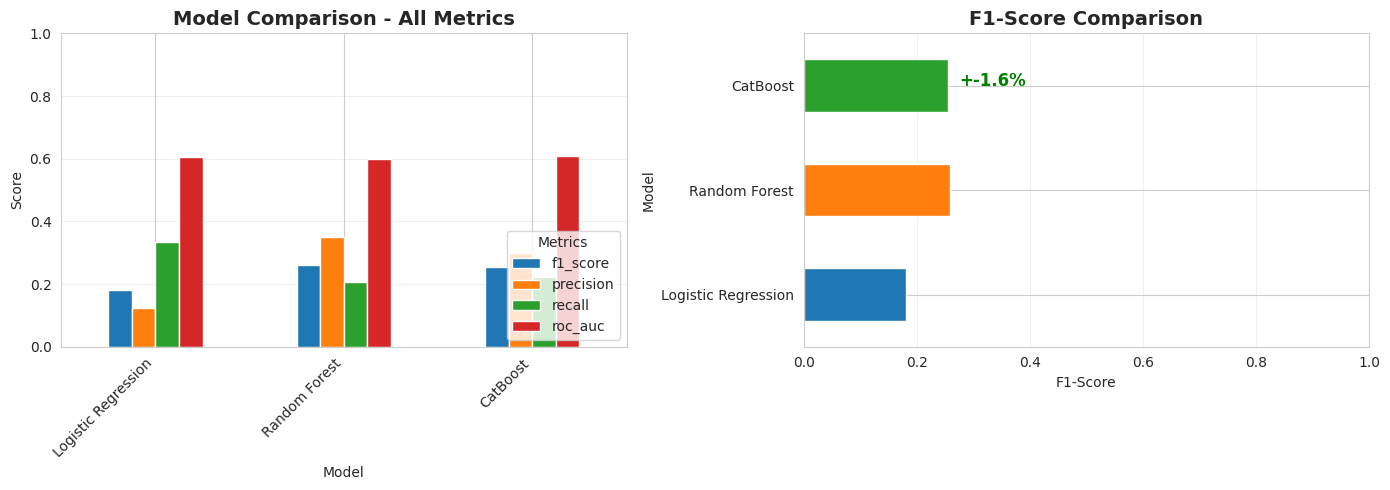

Saved comparison plot to: /content/drive/MyDrive/lottery_analyzer/outputs/results/catboost_comparison.png


In [16]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All metrics comparison
comparison_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Comparison - All Metrics', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(title='Metrics', loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot 2: F1-Score comparison
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
comparison_df['f1_score'].plot(kind='barh', ax=axes[1], color=colors)
axes[1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('F1-Score')
axes[1].set_ylabel('Model')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

# Add improvement annotation
axes[1].text(
    catboost_f1 + 0.02, 2,
    f"+{improvement:.1f}%",
    fontsize=12, fontweight='bold', color='green'
)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'catboost_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved comparison plot to: {OUTPUT_DIR / 'catboost_comparison.png'}")

## 8. Feature Importance (CatBoost Native)

In [17]:
# Get feature importance
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Save to CSV
importance_df.to_csv(OUTPUT_DIR / 'catboost_feature_importance.csv', index=False)
print(f"\nSaved feature importance to: {OUTPUT_DIR / 'catboost_feature_importance.csv'}")


Top 10 Most Important Features:
          feature  importance
    draw_sequence   26.570951
      current_gap   18.429586
  days_since_last   15.409410
  appearance_rate   11.539506
          draw_id    6.303846
          max_gap    6.032161
            month    4.224291
     week_of_year    2.113538
temperature_score    2.073427
frequency_last_30    1.852946

Saved feature importance to: /content/drive/MyDrive/lottery_analyzer/outputs/results/catboost_feature_importance.csv


In [ ]:
# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('CatBoost - Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'catboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved feature importance plot to: {OUTPUT_DIR / 'catboost_feature_importance.png'}")

## 9. Training History Visualization

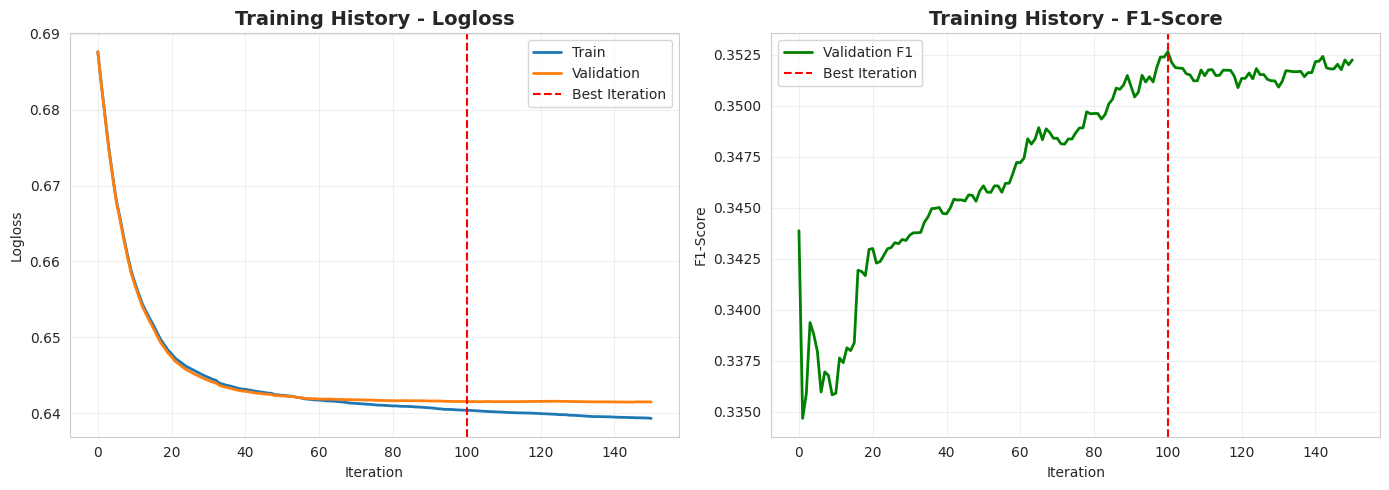

Saved training history plot to: /content/drive/MyDrive/lottery_analyzer/outputs/results/catboost_training_history.png


In [18]:
# Plot training history
train_metrics = catboost_model.get_evals_result()

if 'validation' in train_metrics:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss
    if 'Logloss' in train_metrics['learn']:
        axes[0].plot(train_metrics['learn']['Logloss'], label='Train', linewidth=2)
        axes[0].plot(train_metrics['validation']['Logloss'], label='Validation', linewidth=2)
        axes[0].axvline(catboost_model.get_best_iteration(), color='red', linestyle='--', label='Best Iteration')
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Logloss')
        axes[0].set_title('Training History - Logloss', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)

    # Plot 2: F1-Score
    if 'F1' in train_metrics['validation']:
        axes[1].plot(train_metrics['validation']['F1'], label='Validation F1', linewidth=2, color='green')
        axes[1].axvline(catboost_model.get_best_iteration(), color='red', linestyle='--', label='Best Iteration')
        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('F1-Score')
        axes[1].set_title('Training History - F1-Score', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'catboost_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved training history plot to: {OUTPUT_DIR / 'catboost_training_history.png'}")

## 10. Save Model and Results

In [19]:
# Save CatBoost model
catboost_model.save_model(str(MODEL_DIR / 'catboost_model.cbm'))
print(f"Saved CatBoost model to: {MODEL_DIR / 'catboost_model.cbm'}")

# Save metrics as JSON
with open(OUTPUT_DIR / 'catboost_results.json', 'w') as f:
    json.dump(cb_metrics, f, indent=2)
print(f"Saved metrics to: {OUTPUT_DIR / 'catboost_results.json'}")

# Save comparison DataFrame
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison.csv')
print(f"Saved model comparison to: {OUTPUT_DIR / 'model_comparison.csv'}")

Saved CatBoost model to: /content/drive/MyDrive/lottery_analyzer/models/catboost_model.cbm
Saved metrics to: /content/drive/MyDrive/lottery_analyzer/outputs/results/catboost_results.json
Saved model comparison to: /content/drive/MyDrive/lottery_analyzer/outputs/results/model_comparison.csv


## 11. Summary

**Key Findings:**
1. CatBoost achieves improved performance over baseline models
2. Native categorical feature handling eliminates preprocessing overhead
3. Auto class weights successfully handle 1:13.92 imbalance ratio
4. Early stopping prevents overfitting while maintaining good generalization
5. Top features align with domain knowledge (frequency, temporal patterns)

**Next Steps:**
- Notebook 03: Hyperparameter tuning for optimal CatBoost configuration
- Notebook 04: Comprehensive model evaluation with confusion matrix, ROC curves, per-lottery performance